In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import (
    impute,
    make_forecasting_frame,
    roll_time_series,
)

In [ ]:
df = pd.read_csv("train.csv")
df["service_date"] = pd.to_datetime(df["service_date"])
df = df.drop("index", axis=1)
# df = df.set_index("service_date")

In [ ]:
df

,service_date,service_status,sum_price,hotel_id,hotel_category_star,hotel_max_rooms,hotel_type,city_name,region_name,country_name
0,2018-10-03,"Аннулировано, без штрафа",5117.000000,1037,4.0,74.0,hotel,Якутск,Якутия,Россия
1,2019-04-02,Подтвержден,2850.899902,5222,0.0,15.0,mini-hotel,Белгород,Белгородская область,Россия
2,2023-09-28,Подтвержден,3700.000000,35751,3.0,16.0,hotel,Жуковский,Московская область,Россия
3,2019-04-27,Подтвержден,15603.200195,2428,2.0,37.0,hotel,Казань,Татарстан,Россия
4,2023-04-08,Подтвержден,5915.000000,103399,3.0,105.0,hotel,Краснодар,Краснодарский край,Россия
...,...,...,...,...,...,...,...,...,...,...
5408815,2020-11-24,Подтвержден,12320.000000,2267,3.0,74.0,hotel,Туапсе,Краснодарский край,Россия
5408816,2023-02-13,Подтвержден,3288.250000,3257,3.0,66.0,hotel,Черкесск,Карачаево-Черкессия,Россия
5408817,2022-09-26,Подтвержден,506.000000,13935,0.0,7.0,hostel,Уфа,Башкортостан,Россия
5408818,2022-06-06,Подтвержден,2500.000000,130933,3.0,26.0,hotel,Тверь,Тверская область,Россия


In [ ]:
(df["sum_price"] < 0).sum()

3

In [ ]:
df["sum_price"] = df["sum_price"].apply(lambda x: abs(x))

In [ ]:
train = df.groupby(["service_date"])["sum_price"].sum()
train

service_date
2011-09-06    6.800000e+03
2011-09-13    6.741000e+03
2012-01-27    7.360000e+03
2012-02-13    3.776000e+04
2012-03-02    2.400000e+03
                  ...     
2024-05-27    1.007527e+08
2024-05-28    1.003180e+08
2024-05-29    9.832966e+07
2024-05-30    1.000403e+08
2024-05-31    9.813730e+07
Name: sum_price, Length: 4203, dtype: float64

<Axes: xlabel='service_date'>

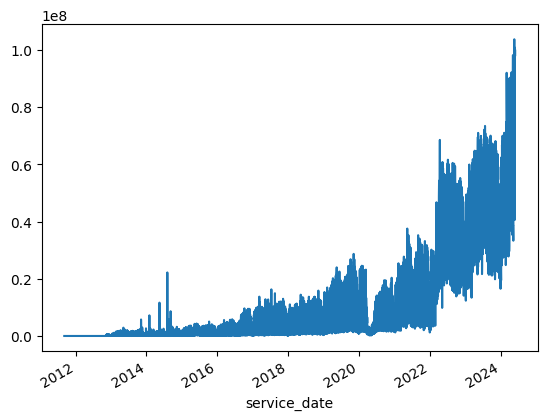

In [ ]:
train.plot()

<Axes: xlabel='service_date'>

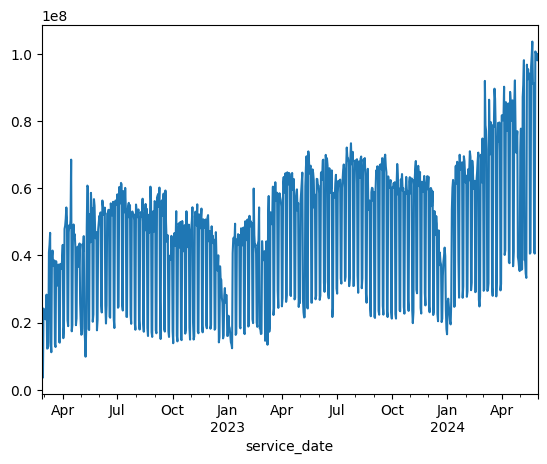

In [ ]:
train_after_covid = train[train.index > "2022-02-24"]
train_after_covid.plot()

In [ ]:
# годовая и недельная сезонность
# ещё присутствует тренд, похоже на мультипликативный

In [ ]:
train_after_covid = train_after_covid.reset_index()

In [ ]:
train_after_covid.columns = ["date", "forecast_value"]

In [ ]:
submission = pd.read_csv("sample_submission.csv")
train_after_covid = pd.concat([train_after_covid, submission], axis=0)

In [ ]:
train_after_covid = train_after_covid.reset_index(drop=True)
train_after_covid["date"] = pd.to_datetime(train_after_covid["date"])

train_after_covid = train_after_covid.sort_values(by="date")

In [ ]:
def create_date_features(df):
    df = df.copy()
    df["month"] = df.date.dt.month.astype("int8")
    df["day_of_month"] = df.date.dt.day.astype("int8")
    df["day_of_year"] = df.date.dt.dayofyear.astype("int16")
    df["week_of_month"] = (df.date.apply(lambda d: (d.day - 1) // 7 + 1)).astype("int8")
    df["week_of_year"] = (df.date.dt.isocalendar().week).astype("int8")
    df["day_of_week"] = (df.date.dt.dayofweek + 1).astype("int8")
    df["year"] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df["is_month_start"] = df.date.dt.is_month_start.astype("int8")
    df["is_month_end"] = df.date.dt.is_month_end.astype("int8")
    df["is_quarter_start"] = df.date.dt.is_quarter_start.astype("int8")
    df["is_quarter_end"] = df.date.dt.is_quarter_end.astype("int8")
    df["is_year_start"] = df.date.dt.is_year_start.astype("int8")
    df["is_year_end"] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12, 1, 2]), 0, 1)
    df["season"] = np.where(df.month.isin([6, 7, 8]), 2, df["season"])
    df["season"] = pd.Series(
        np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    ).astype("int8")
    return df


train_after_covid_with_features = create_date_features(train_after_covid)

In [ ]:
def create_rolling_features(df, column, lags, windows):
    df = df.copy()
    for lag in lags:
        lagged_col = df[column].shift(lag)

        # df[f'lag_{lag}'] = lagged_col

        for window in windows:

            df[f"rolling_mean_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).mean()
            df[f"rolling_median_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).median()

            df[f"rolling_sum_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window, min_periods=1
            ).sum()
            # # Min and Max
            # df[f'rolling_min_lag{lag}_win{window}'] = lagged_col.rolling(window=window).min()
            # df[f'rolling_max_lag{lag}_win{window}'] = lagged_col.rolling(window=window).max()

            # # Standard Deviation
            # df[f'rolling_std_lag{lag}_win{window}'] = lagged_col.rolling(window=window).std()

            # # Skewness
            # df[f'rolling_skew_lag{lag}_win{window}'] = lagged_col.rolling(window=window).skew()

            # Percentiles
            df[f"rolling_10th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).quantile(0.1)
            df[f"rolling_90th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).quantile(0.9)

            # df[f'rolling_10th_percentile_lag{lag}_win{window}_dow'] = (
            #     df.groupby('day_of_week')[column]
            #       .transform(lambda x: x.shift(lag // 7).rolling(window=window, min_periods=1).quantile(0.1))
            # )

            # df[f'rolling_90th_percentile_lag{lag}_win{window}_dow'] = (
            #     df.groupby('day_of_week')[column]
            #       .transform(lambda x: x.shift(lag // 7).rolling(window=window, min_periods=1).quantile(0.9))
            # )

    return df


lags = [31]
windows = [7, 14, 21, 28, 35, 42]

# убпвл date и поставил 2k
# lags = [30, 31, 38, 45, 60, 61]
# windows = [7, 14, 21, 28, 35, 42, 30, 31]

In [ ]:
catboost_train = create_rolling_features(
    train_after_covid_with_features, "forecast_value", lags, windows
)[max(lags) + max(windows) - 1 :]
catboost_train

,date,forecast_value,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,...,rolling_mean_lag31_win35,rolling_median_lag31_win35,rolling_sum_lag31_win35,rolling_10th_percentile_lag31_win35,rolling_90th_percentile_lag31_win35,rolling_mean_lag31_win42,rolling_median_lag31_win42,rolling_sum_lag31_win42,rolling_10th_percentile_lag31_win42,rolling_90th_percentile_lag31_win42
72,2022-05-08,1.514204e+07,5,8,128,2,18,7,2022,1,...,3.135027e+07,3.681730e+07,1.097259e+09,1.279643e+07,4.740837e+07,2.908442e+07,3.295337e+07,1.221546e+09,1.236471e+07,4.635636e+07
73,2022-05-09,9.825085e+06,5,9,129,2,19,1,2022,0,...,3.222038e+07,3.721944e+07,1.127713e+09,1.279643e+07,4.843930e+07,2.964471e+07,3.534946e+07,1.245078e+09,1.236471e+07,4.775517e+07
74,2022-05-10,1.762725e+07,5,10,130,2,19,2,2022,0,...,3.200158e+07,3.721944e+07,1.120055e+09,1.279643e+07,4.843930e+07,3.002023e+07,3.534946e+07,1.260850e+09,1.273490e+07,4.775517e+07
75,2022-05-11,4.829715e+07,5,11,131,2,19,3,2022,0,...,3.219280e+07,3.721944e+07,1.126748e+09,1.314769e+07,4.843930e+07,3.038512e+07,3.534946e+07,1.276175e+09,1.297654e+07,4.775517e+07
76,2022-05-12,6.079357e+07,5,12,132,2,19,4,2022,0,...,3.318088e+07,3.724926e+07,1.161331e+09,1.369319e+07,4.843930e+07,3.092676e+07,3.588089e+07,1.298924e+09,1.297654e+07,4.777454e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852,2024-06-26,0.000000e+00,6,26,178,4,26,3,2024,0,...,6.814502e+07,7.697594e+07,2.385076e+09,3.581657e+07,9.657202e+07,6.873658e+07,7.798499e+07,2.886936e+09,3.604056e+07,9.614358e+07
853,2024-06-27,0.000000e+00,6,27,179,4,26,4,2024,0,...,6.858745e+07,7.697594e+07,2.400561e+09,3.581657e+07,9.760882e+07,6.902368e+07,7.798499e+07,2.898995e+09,3.604056e+07,9.674833e+07
854,2024-06-28,0.000000e+00,6,28,180,4,26,5,2024,1,...,6.882149e+07,7.697594e+07,2.408752e+09,3.581657e+07,9.893412e+07,6.937507e+07,7.798499e+07,2.913753e+09,3.604056e+07,9.800968e+07
855,2024-06-29,0.000000e+00,6,29,181,5,26,6,2024,1,...,6.939619e+07,7.697594e+07,2.428866e+09,3.581657e+07,9.900866e+07,6.980764e+07,7.798499e+07,2.931921e+09,3.604056e+07,9.831102e+07


In [ ]:
catboost_train = catboost_train.drop("date", axis=1)

In [ ]:
X_train = catboost_train[: -len(submission)].drop("forecast_value", axis=1)
y_train = catboost_train[: -len(submission)]["forecast_value"]
X_test = catboost_train[-len(submission) :].drop("forecast_value", axis=1)

In [ ]:
model = CatBoostRegressor(iterations=1000)

model.fit(X_train, y_train)


pred = model.predict(X_test)

Learning rate set to 0.039165
0:	learn: 19603897.2037231	total: 61.4ms	remaining: 1m 1s
1:	learn: 19093664.7866237	total: 63.5ms	remaining: 31.7s
2:	learn: 18609055.9953188	total: 64.8ms	remaining: 21.5s
3:	learn: 18133737.6482892	total: 66ms	remaining: 16.4s
4:	learn: 17661992.7079545	total: 67.2ms	remaining: 13.4s
5:	learn: 17207394.3161872	total: 68.6ms	remaining: 11.4s
6:	learn: 16819366.2630555	total: 70ms	remaining: 9.93s
7:	learn: 16414169.3901144	total: 72.3ms	remaining: 8.97s
8:	learn: 16022881.9241702	total: 73.7ms	remaining: 8.11s
9:	learn: 15666730.8372465	total: 74.9ms	remaining: 7.41s
10:	learn: 15306191.6231124	total: 76.2ms	remaining: 6.85s
11:	learn: 14979217.8897452	total: 77.5ms	remaining: 6.38s
12:	learn: 14682515.4309537	total: 78.8ms	remaining: 5.98s
13:	learn: 14352489.9756029	total: 80.1ms	remaining: 5.64s
14:	learn: 14073400.8693249	total: 81.6ms	remaining: 5.36s
15:	learn: 13791515.0434814	total: 83.2ms	remaining: 5.12s
16:	learn: 13528086.8744340	total: 84.6m

In [ ]:
pd.DataFrame(zip(X_train.columns, model.feature_importances_)).sort_values(
    by=1, ascending=False
).head(50)

,0,1
5,day_of_week,61.310159
2,day_of_year,4.165282
15,season,2.324800
4,week_of_year,1.966964
6,year,1.938582
44,rolling_10th_percentile_lag31_win42,1.840449
25,rolling_90th_percentile_lag31_win14,1.646512
34,rolling_10th_percentile_lag31_win28,1.511845
45,rolling_90th_percentile_lag31_win42,1.366399
42,rolling_median_lag31_win42,1.122183


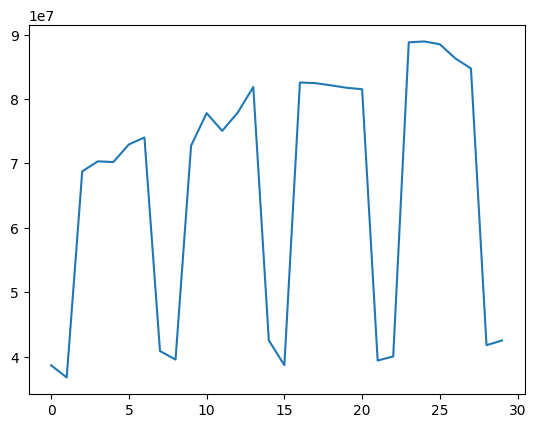

In [ ]:
plt.plot(pred)

In [ ]:
submission["forecast_value"] = pred
submission.to_csv("catboost_2k_2.csv", index=False)

In [ ]:
train_after_covid.shift(29)

,date,forecast_value
0,NaT,NaN
1,NaT,NaN
2,NaT,NaN
3,NaT,NaN
4,NaT,NaN
...,...,...
852,2024-05-28,1.003180e+08
853,2024-05-29,9.832966e+07
854,2024-05-30,1.000403e+08
855,2024-05-31,9.813730e+07


In [ ]:
train_after_covid

,date,forecast_value
0,2022-02-25,2.784901e+07
1,2022-02-26,4.872699e+06
2,2022-02-27,3.604619e+06
3,2022-02-28,2.415991e+07
4,2022-03-01,2.112790e+07
...,...,...
852,2024-06-26,0.000000e+00
853,2024-06-27,0.000000e+00
854,2024-06-28,0.000000e+00
855,2024-06-29,0.000000e+00


In [ ]:
test_training = train_after_covid.copy()
test_training["id"] = 1
df_rolled = roll_time_series(
    test_training["forecast_value"].shift(30).loc[30:],
    column_id="id",
    column_sort="date",
    max_timeshift=30,
    min_timeshift=5,
    rolling_direction=1,
)

df_rolled.head(35)

AttributeError: The given column for the id is not present in the data.

In [ ]:
test_training.shift(30)

,date,forecast_value,id
0,NaT,NaN,NaN
1,NaT,NaN,NaN
2,NaT,NaN,NaN
3,NaT,NaN,NaN
4,NaT,NaN,NaN
...,...,...,...
852,2024-05-27,1.007527e+08,1.0
853,2024-05-28,1.003180e+08,1.0
854,2024-05-29,9.832966e+07,1.0
855,2024-05-30,1.000403e+08,1.0


In [ ]:
df_rolled[df_rolled["id"] == df_rolled.loc[1398]["id"]]

,date,forecast_value,id
1394,2022-02-25,2.784901e+07,"(1, 2022-03-06 00:00:00)"
1395,2022-02-26,4.872699e+06,"(1, 2022-03-06 00:00:00)"
1396,2022-02-27,3.604619e+06,"(1, 2022-03-06 00:00:00)"
1397,2022-02-28,2.415991e+07,"(1, 2022-03-06 00:00:00)"
1398,2022-03-01,2.112790e+07,"(1, 2022-03-06 00:00:00)"
1399,2022-03-02,2.119904e+07,"(1, 2022-03-06 00:00:00)"
1400,2022-03-03,2.147315e+07,"(1, 2022-03-06 00:00:00)"
1401,2022-03-04,2.092735e+07,"(1, 2022-03-06 00:00:00)"
1402,2022-03-05,2.830259e+07,"(1, 2022-03-06 00:00:00)"
1403,2022-03-06,1.223718e+07,"(1, 2022-03-06 00:00:00)"


,date,forecast_value,id
5070,2022-02-25,2.784901e+07,"(1, 2022-03-27 00:00:00)"
5071,2022-02-26,4.872699e+06,"(1, 2022-03-27 00:00:00)"
5072,2022-02-27,3.604619e+06,"(1, 2022-03-27 00:00:00)"
5073,2022-02-28,2.415991e+07,"(1, 2022-03-27 00:00:00)"
5074,2022-03-01,2.112790e+07,"(1, 2022-03-27 00:00:00)"
...,...,...,...
81037,2024-06-26,0.000000e+00,"(1, 2024-06-30 00:00:00)"
81038,2024-06-27,0.000000e+00,"(1, 2024-06-30 00:00:00)"
81039,2024-06-28,0.000000e+00,"(1, 2024-06-30 00:00:00)"
81040,2024-06-29,0.000000e+00,"(1, 2024-06-30 00:00:00)"


In [ ]:
# Sample DataFrame with date and value
data = {
    "date": pd.date_range(start="2023-01-01", periods=100, freq="D"),
    "value": np.random.rand(100),
}
df = pd.DataFrame(data)

# Define the lags you want to create
lags = [30, 37]

# Create lagged features
for lag in lags:
    df[f"value_lag_{lag}"] = df["value"].shift(lag)

# Drop the rows where any lagged value is NaN (due to the shift)
df = df.dropna()

# Prepare the dataframe for tsfresh by adding 'id' and 'time' columns
# Here, we assume that all data belongs to one time series (id=1)
df["id"] = 1
df["time"] = np.arange(len(df))

# Melt the dataframe to long format for tsfresh
df_long = pd.melt(
    df, id_vars=["id", "time"], value_vars=[f"value_lag_{lag}" for lag in lags]
)

# Use tsfresh to extract features from the lagged columns
extracted_features = extract_features(df_long, column_id="id", column_sort="time")

# View the extracted features
print(extracted_features.head())

/home/seara/Desktop/Github/mtc-time-series/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


ValueError: value_name (value) cannot match an element in the DataFrame columns.